In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import time

import numpy as np
import mxnet as mx
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from metadata import *
from data_manager import *
from learning_utilities import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
No vtk


Setting environment for Precision WorkStation


File does not exist: /media/yuncong/BstemAtlasData/CSHL_data_processed//MD653/MD653_anchor.txt
File does not exist: /media/yuncong/BstemAtlasData/CSHL_data_processed/MD653/MD653_sorted_filenames.txt
File does not exist: /media/yuncong/BstemAtlasData/CSHL_data_processed//MD653/MD653_cropbox.txt
File does not exist: /media/yuncong/BstemAtlasData/CSHL_data_processed//MD653/MD653_cropbox.txt
File does not exist: /media/yuncong/BstemAtlasData/CSHL_data_processed//MD652/MD652_anchor.txt
File does not exist: /media/yuncong/BstemAtlasData/CSHL_data_processed/MD652/MD652_sorted_filenames.txt
File does not exist: /media/yuncong/BstemAtlasData/CSHL_data_processed//MD652/MD652_cropbox.txt
File does not exist: /media/yuncong/BstemAtlasData/CSHL_data_processed//MD652/MD652_cropbox.txt


In [2]:
MODEL_ROOTDIR = '/home/yuncong/mxnet_models/'

# Convert to using one channel input

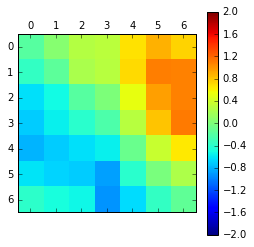

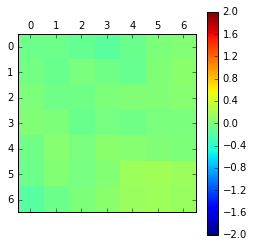

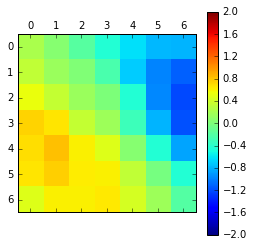

In [32]:
# Different channels are different. So using only the weights of one channel is ad-hoc.

plt.matshow(np.squeeze(init_model.arg_params['conv_1_weight'].asnumpy()[:,[0],:,:])[2], vmin=-2, vmax=2)
plt.colorbar();
plt.show();

plt.matshow(np.squeeze(init_model.arg_params['conv_1_weight'].asnumpy()[:,[1],:,:])[2], vmin=-2, vmax=2)
plt.colorbar();
plt.show();

plt.matshow(np.squeeze(init_model.arg_params['conv_1_weight'].asnumpy()[:,[2],:,:])[2], vmin=-2, vmax=2)
plt.colorbar();
plt.show();

# Inception-BN

In [121]:
init_model.symbol.get_internals().list_outputs()

['data',
 'conv_1_weight',
 'conv_1_bias',
 'conv_1_output',
 'bn_1_gamma',
 'bn_1_beta',
 'bn_1_moving_mean',
 'bn_1_moving_var',
 'bn_1_output',
 'relu_1_output',
 'pool_1_output',
 'conv_2_red_weight',
 'conv_2_red_bias',
 'conv_2_red_output',
 'bn_2_red_gamma',
 'bn_2_red_beta',
 'bn_2_red_moving_mean',
 'bn_2_red_moving_var',
 'bn_2_red_output',
 'relu_2_red_output',
 'conv_2_weight',
 'conv_2_bias',
 'conv_2_output',
 'bn_2_gamma',
 'bn_2_beta',
 'bn_2_moving_mean',
 'bn_2_moving_var',
 'bn_2_output',
 'relu_2_output',
 'pool_2_output',
 'conv_3a_1x1_weight',
 'conv_3a_1x1_bias',
 'conv_3a_1x1_output',
 'bn_3a_1x1_gamma',
 'bn_3a_1x1_beta',
 'bn_3a_1x1_moving_mean',
 'bn_3a_1x1_moving_var',
 'bn_3a_1x1_output',
 'relu_3a_1x1_output',
 'conv_3a_3x3_reduce_weight',
 'conv_3a_3x3_reduce_bias',
 'conv_3a_3x3_reduce_output',
 'bn_3a_3x3_reduce_gamma',
 'bn_3a_3x3_reduce_beta',
 'bn_3a_3x3_reduce_moving_mean',
 'bn_3a_3x3_reduce_moving_var',
 'bn_3a_3x3_reduce_output',
 'relu_3a_3x3_re

In [117]:
# In order for input to be saturation channel of patches, only use the blue channel in the first convolution layer.

channel = 2

model_dir_name = 'inception-bn'
model_name = 'Inception-BN'
model_iteration = 126

output_symbol_name = 'flatten_output'
output_dim = 1024

init_model = mx.model.FeedForward.load(os.path.join(MODEL_ROOTDIR, model_dir_name, model_name), 
                                       model_iteration, 
                                       ctx=mx.gpu())

arg_params = init_model.arg_params.copy()
# arg_params.pop('fc1_bias');
# arg_params.pop('fc1_weight');
arg_params['conv_1_weight'] = mx.ndarray.array(init_model.arg_params['conv_1_weight'].asnumpy()[:,[channel],:,:])

flatten_output = init_model.symbol.get_internals()[output_symbol_name]

net = mx.model.FeedForward(ctx=mx.gpu(), 
                           symbol=flatten_output, 
                           num_epoch=0,
                           arg_params = arg_params, 
                           aux_params = init_model.aux_params,
                           allow_extra_params = True)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:28: DeprecationWarning: mxnet.model.FeedForward has been deprecated. Please use mxnet.mod.Module instead.


In [118]:
new_model_dir_name = 'inception-bn-blue'
new_model_name = 'inception-bn-blue'
model_fp = os.path.join(MODEL_ROOTDIR, new_model_dir_name, new_model_name)
create_parent_dir_if_not_exists(model_fp)
net.save(model_fp)

In [119]:
mean_img = mx.nd.load(os.path.join(MODEL_ROOTDIR, model_dir_name, 'mean_224.nd'))['mean_img'].asnumpy()[channel]
np.save(os.path.join(MODEL_ROOTDIR, new_model_dir_name, 'mean_224'), mean_img)

# VGG

In [113]:
# In order for input to be saturation channel of patches, only use the blue channel in the first convolution layer.

channel = 2

model_dir_name = 'vgg16'
model_name = 'vgg16'
model_iteration = 0

# output_symbol_name = 'flatten_0_output'
# output_dim = 25088

# output_symbol_name = 'fc6_output'
# output_dim = 4096

output_symbol_name = 'fc7_output'
output_dim = 4096

init_model = mx.model.FeedForward.load(os.path.join(MODEL_ROOTDIR, model_dir_name, model_name), 
                                       model_iteration, 
                                       ctx=mx.gpu())

arg_params = init_model.arg_params.copy()
# arg_params.pop('fc8_bias');
# arg_params.pop('fc8_weight');
arg_params['conv1_1_weight'] = mx.ndarray.array(init_model.arg_params['conv1_1_weight'].asnumpy()[:,[channel],:,:])

flatten_output = init_model.symbol.get_internals()[output_symbol_name]

net = mx.model.FeedForward(ctx=mx.gpu(), 
                           symbol=flatten_output, 
                           num_epoch=0,
                           arg_params = arg_params, 
                           aux_params = init_model.aux_params,
                           allow_extra_params = True)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:34: DeprecationWarning: mxnet.model.FeedForward has been deprecated. Please use mxnet.mod.Module instead.


In [114]:
new_model_dir_name = 'vgg16-blue'
new_model_name = 'vgg16-blue'
model_fp = os.path.join(MODEL_ROOTDIR, new_model_dir_name, new_model_name)
create_parent_dir_if_not_exists(model_fp)
net.save(model_fp)

In [115]:
mean_img = np.load(os.path.join(MODEL_ROOTDIR, model_dir_name, 'vgg_mean.npy'))
np.save(os.path.join(MODEL_ROOTDIR, new_model_dir_name, 'vgg_mean.npy'), mean_img[..., channel])

In [ ]:
# 

In [120]:
# Visualize network topology
a = mx.viz.plot_network(init_model.symbol.get_internals()[output_symbol_name], shape={"data":(1, 1, 224, 224)}, node_attrs={"shape":'rect',"fixedsize":'false'})
a.render(new_model_name)

'inception-bn-blue.pdf'

# finetune

In [2]:
structures_to_sample = all_known_structures

negative_labels_to_sample = [s + '_negative' for s in structures_to_sample]

margins_to_sample = [200, 500]
surround_labels_to_sample = [convert_to_surround_name(s, margin=m, suffix=surr_l) 
                             for m in margins_to_sample
                             for s in structures_to_sample 
                             for surr_l in structures_to_sample + ['noclass'] 
                             if surr_l != s]

labels_to_sample = structures_to_sample + negative_labels_to_sample + surround_labels_to_sample + ['noclass']

In [ ]:
# initial model

model_dir_name = 'inception-bn'
model_name = 'Inception-BN'
model_iteration = 126

init_model = mx.model.FeedForward.load(os.path.join(MODEL_ROOTDIR, model_dir_name, model_name), 
                                       model_iteration, 
                                       ctx=mx.gpu())

arg_params = init_model.arg_params.copy()
arg_params.pop('fc1_bias');
arg_params.pop('fc1_weight');
arg_params['conv_1_weight'] = mx.ndarray.array(init_model.arg_params['conv_1_weight'].asnumpy()[:,[0],:,:])

n_class = len(labels_to_sample)
flatten_output = init_model.symbol.get_internals()['flatten_output']
fc = mx.symbol.FullyConnected(data=flatten_output, name='fullc', num_hidden=n_class)
softmax = mx.symbol.SoftmaxOutput(data=fc, name='softmax')

In [ ]:
net = mx.model.FeedForward(ctx=mx.gpu(), 
                           symbol=softmax, 
                           num_epoch=n_epoch, optimizer=opt,
                           arg_params = arg_params, 
                           aux_params = init_model.aux_params,
                           allow_extra_params = True)

In [ ]:
n_epoch = 10
l_rate = 0.001
checkpoint_prefix = os.path.join(MODEL_ROOTDIR, model_dir_name, 'Sat28ClassFinetuned')

opt = mx.optimizer.SGD(learning_rate=l_rate)

net = mx.model.FeedForward(ctx=mx.gpu(), 
                           symbol=softmax, 
                           num_epoch=n_epoch, optimizer=opt,
                           arg_params = arg_params, 
                           aux_params = init_model.aux_params,
                           allow_extra_params = True)

In [ ]:
dataset = 2

In [ ]:
# load training addresses
training_addresses = load_pickle(os.path.join(CLF_ROOTDIR, 'datasets', 'dataset_%d' % dataset, 'patch_addresses.pkl'))
training_addresses = {l: addrs for l, addrs in training_addresses.iteritems() if l in labels_to_sample}

In [ ]:
training_patches = {label: extract_patches_given_locations_multiple_sections(addresses[:10], 
                                                            location_or_grid_index='grid_index',
                                                           version='compressed')
                    for label, addresses in training_addresses.iteritems()}

In [ ]:
# Below is half-finished ...

In [ ]:
for stack in ['MD642']:

    print stack

    section_to_filename = metadata_cache['sections_to_filenames'][stack]
    anchor_fn = metadata_cache['anchor_fn'][stack]

    image_width, image_height = metadata_cache['image_shape'][stack]
    grid_spec = (patch_size, stride, image_width, image_height)

    sample_locations = grid_parameters_to_sample_locations(grid_spec=grid_spec)

    first_detect_sec, last_detect_sec = metadata_cache['section_limits'][stack]

    bar = show_progress_bar(first_detect_sec, last_detect_sec)

    for sec in range(first_detect_sec, last_detect_sec):
        sat = imread(DataManager.get_image_filepath(stack=stack, section=sec, version='saturation'))
    

        t = time.time()

    #         patches = np.array([sat[y-half_size:y+half_size, x-half_size:x+half_size].copy()
    #                             for x, y in sample_locations_roi]) # n x 224 x 224

        patches = np.array([sat[y-half_size:y+half_size, x-half_size:x+half_size]
                            for x, y in sample_locations_roi]) # n x 224 x 224

        patches_mean_subtracted = patches - mean_img

        patches_mean_subtracted_input = patches_mean_subtracted[:, None, :, :] # n x 1 x 224 x 224
        #         patches = np.rollaxis(patches2, 3, 1)

        sys.stderr.write('extract, reshape, normalize: %.2f seconds\n' % (time.time() - t)) # ~ 4s / 20k patches

    #         batch_size = 256 # increasing to 500 does not save any time
        batch_size = 16 # increasing to 500 does not save any time

    data_iter = mx.io.NDArrayIter(
        patches_mean_subtracted_input, 
        np.zeros((n, ), np.int), # labels are not important since it is just feed-forward
        batch_size = batch_size,
        shuffle=False
    )

    t = time.time()

    features = model.fit(data_iter,
                        batch_end_callback=mx.callback.Speedometer(batch_size, 30),
                        epoch_end_callback=mx.callback.do_checkpoint(checkpoint_prefix))
    net.save(checkpoint_prefix)

    sys.stderr.write('predict: %.2f seconds\n' % (time.time() - t))